In [ ]:
from numpy import mean
from numpy import std
from numpy import dstack
import numpy as np
import pandas as pd
import re
import json
from pandas.io.json import json_normalize
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.utils import to_categorical
from keras.layers import ConvLSTM2D
from keras.optimizers import Adam
from matplotlib import pyplot

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

helper functions

In [ ]:
def loadData(path):
    with open(path,'r') as handle:
        text_data = handle.read()
        json_data = json.loads(text_data)
        df = pd.DataFrame(json_data)
    return df


#Adding frame numbers for time series plots
def LabelFrame(data):   
    df = pd.DataFrame(data)
    for i in range(len(df.ObjectList.index)):
        for j in df['ObjectList'][i]:
            j['Frame'] = i
            
    df.to_json('temp.json',orient = 'records')
    with open('temp.json') as file:
        data2 = file.read()
        jasondata = json.loads(data2)
    return jasondata


def openfile(path):
    with open(path, 'r') as handle:
        text_data = handle.read()
        text_data = '[' + re.sub(r'\}\s\{','},{', text_data) + ']'
        json_data = json.loads(text_data)
        json_data = LabelFrame(json_data)
    return json_data


#Seperating pk array values into columns
def mergedframe1(df_1):
        frames = [df_1]
        df_merged = pd.concat(frames,ignore_index = True)
        df_classify = pd.DataFrame()
        df_classify[['ObjType','pkArray','dpplIdx']] = df_merged[['ObjType','pkArray','dpplIdx']]
        
        df_classify['pkArray'] = df_classify['pkArray'].apply(lambda pkarray:np.ravel(np.transpose(pkarray)))
        
        all_list = []

        for i in range(35):
            for j in range(len(df_classify.index)):
                all_list.append(df_classify.pkArray[j][i])
        chunk = [all_list[i:i+len(df_classify.index)] for i in range(0, len(all_list), len(df_classify.index))]
        df_classify1 = pd.DataFrame(chunk)
        dfclassify=df_classify1.transpose()
        dfclassify['ObjType'] = df_classify['ObjType']
        dfclassify['rangeIdx'] = df_merged['rangeIdx']
        dfclassify['dpplIdx'] = df_merged['dpplIdx']
        dfclassify['pkArray'] = df_merged['pkArray']
        dfclassify['Range'] = df_merged['Range']
        dfclassify['Coordinates.X'] = df_merged['Coordinates.X']
        dfclassify['Coordinates.Y'] = df_merged['Coordinates.Y']
        dfclassify["pkValue1.Real"] = df_merged["pkValue1.Real"]
        dfclassify["pkValue1.Imaginary"] = df_merged['pkValue1.Imaginary']
        dfclassify["pkValue2.Real"] = df_merged["pkValue2.Real"]
        dfclassify["pkValue2.Imaginary"] = df_merged['pkValue2.Imaginary']
        dfclassify["pkValue3.Real"] = df_merged["pkValue3.Real"]
        dfclassify["pkValue3.Imaginary"] = df_merged['pkValue3.Imaginary']
        dfclassify["pkValue4.Real"] = df_merged["pkValue4.Real"]
        dfclassify["pkValue4.Imaginary"] = df_merged['pkValue4.Imaginary']
        
        dfclassify['Frame'] = df_merged['Frame']
        dfclassify['Range'] = df_merged['Range']
        return dfclassify


# Load all files from json to a dataframe after 
def startdf(json_data,Label):
    df_1= pd.DataFrame()
    df1 = pd.DataFrame((json_data))
    for j in range(len(df1.index)):
        df2 = json_normalize(df1['ObjectList'][j])
        df2['ObjType'] = df2['ObjType'].map(lambda ObjType: Label)        
        #df2 = df2[df2.Range <= UIdx]
        #df2 = df2[df2.Range >= LIdx]
        #df2 = df2[df2.dpplIdx == 1]   
        df_1 = pd.concat([df2,df_1],ignore_index =True)
    df_1 = df_1.sort_values(by=['Frame'],ascending = True)
    df_1 = df_1.reset_index(drop=True)
    df_1['pkArray'] = df_1['pkArray'].map(lambda x:np.transpose(x))
    df_final = mergedframe1(df_1)
    return df_final


def labelData(df, x1, x2, y1, y2, label):
    df['ObjType'] = df['ObjType'].map(lambda x : 0)

    for index, row in df.iterrows():
        if ((row['Coordinates.X'] > x1) & (row['Coordinates.X'] < x2) 
        & (row['Coordinates.Y'] > y1) & (row['Coordinates.Y'] < y2)):
            df.at[index, 'ObjType'] = label
    return df


# Shuffle two arrays in unison
def unison_shuffled_copies(array1, array2):
    assert len(array1) == len(array2)
    p = np.random.permutation(len(array1))
    return array1[p], array2[p]


def padHumanRows(df):
  for ind, row in df.iterrows():
    if ((ind % 10) == 0):
      count = 0
      while ((count < 10) and (df.iloc[ind + count]['Frame'] == int(ind/10))):
        count = count + 1
        if ((ind + count) == len(df.index)):
          break
      while (count < 10):
        row = pd.DataFrame({"0": 0, "1": 0, "2": 0, "3": 0, "4": 0, "5": 0, "6": 0, "7": 0, "8": 0, "9": 0, "10": 0, "11": 0, "12": 0, "13": 0, "14": 0, "15": 0, "16": 0, "17": 0, "18": 0, "19": 0, "20": 0, "21": 0, "22": 0, "23": 0, "24": 0, "25": 0, "26": 0, "27": 0, "28": 0, "29": 0, "30": 0, "31": 0, "32": 0, "33": 0, "34": 0, "Frame": ind/10}, index=[ind+count-1+0.5])
        df = df.append(row, ignore_index=False)
        df = df.sort_index().reset_index(drop=True)
        df = df.reindex(["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20", "21", "22", "23", "24", "25", "26", "27", "28", "29", "30", "31", "32", "33", "34", "Frame"], axis=1)
        count = count + 1
  return df

def padCarRows(df):
  for ind, row in df.iterrows():
    if ((ind % 10) == 0):
      count = 0
      while ((count < 10) and (df.iloc[ind + count]['Frame'] == int(ind/10))):
        count = count + 1
        if ((ind + count) == len(df.index)):
          break
      while (count < 10):
        row = pd.DataFrame({0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, "Frame": ind/10}, index=[ind+count-1+0.5])
        df = df.append(row, ignore_index=False)
        df = df.sort_index().reset_index(drop=True)
        df = df.reindex([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, "Frame"], axis=1)
        count = count + 1
  return df


def padRows(df, obj):
  if (obj == "car"):
    while (df.shape[0] != ((df['Frame'].max() + 1)*10)):
      df = padCarRows(df)
  else:
    while (df.shape[0] != ((df['Frame'].max() + 1)*10)):
      df = padHumanRows(df)  
  return df


def truncateColumns(df):
  df.drop(['rangeIdx', 'dpplIdx', 'pkArray', 'Range', 'Coordinates.X', 
                  'Coordinates.Y', 'pkValue1.Real', 'pkValue1.Imaginary', 
                  'pkValue2.Real', 'pkValue2.Imaginary', 'pkValue3.Real', 
                  'pkValue3.Imaginary', 'pkValue4.Real', 'pkValue4.Imaginary', 
                  'ObjType'], axis=1)
  return df


def dfTo2DArray(df):
  df = df[df.columns[0:35]].values
  return df

load human data from json files

In [ ]:
#training
humanDay1_2pm = loadData("/content/drive/My Drive/UAY-Invecas-IITH/Radar_ML_Models/virendraConvLSTM/filesUsedForTraining/human/human_2pm.json")
humanDay1_5pm = loadData("/content/drive/My Drive/UAY-Invecas-IITH/Radar_ML_Models/virendraConvLSTM/filesUsedForTraining/human/human_5pm.json")
humanDay1_9pm = loadData("/content/drive/My Drive/UAY-Invecas-IITH/Radar_ML_Models/virendraConvLSTM/filesUsedForTraining/human/human_9pm.json")

#testing
humanDay1_3pm = loadData("/content/drive/My Drive/UAY-Invecas-IITH/Radar_ML_Models/virendraConvLSTM/filesUsedForTesting/human/human_3pm.json")
humanDay1_6pm = loadData("/content/drive/My Drive/UAY-Invecas-IITH/Radar_ML_Models/virendraConvLSTM/filesUsedForTesting/human/human_6pm.json")

load Car Vertical data from json files

Naming Format -> **carVday1_5** -> car vertical data recorded at 5m on day1 

In [ ]:
#training data
carVday1_6 = startdf(openfile("/content/drive/My Drive/UAY-Invecas-IITH/Radar_ML_Models/virendraConvLSTM/filesUsedForTraining/carV/Car Vertical_6_27_01_2020 12_42_51.json"), 2)
carVday1_10 = startdf(openfile("/content/drive/My Drive/UAY-Invecas-IITH/Radar_ML_Models/virendraConvLSTM/filesUsedForTraining/carV/Car Vertical_10_27_01_2020 12_46_59.json"), 2)
carVday1_16 = startdf(openfile("/content/drive/My Drive/UAY-Invecas-IITH/Radar_ML_Models/virendraConvLSTM/filesUsedForTraining/carV/Car Vertical_16_27_01_2020 12_53_52.json"), 2)
carVday1_19 = startdf(openfile("/content/drive/My Drive/UAY-Invecas-IITH/Radar_ML_Models/virendraConvLSTM/filesUsedForTraining/carV/Car Vertical_19_27_01_2020 12_57_35.json"), 2)
carVday1_2 = startdf(openfile("/content/drive/My Drive/UAY-Invecas-IITH/Radar_ML_Models/virendraConvLSTM/filesUsedForTraining/carV/Car Vertical_2_27_01_2020 12_38_30.json"), 2)
carVday1_13 = startdf(openfile("/content/drive/My Drive/UAY-Invecas-IITH/Radar_ML_Models/virendraConvLSTM/filesUsedForTraining/carV/Car Vertical_13_27_01_2020 12_50_12.json"), 2)
carVday1_4 = startdf(openfile("/content/drive/My Drive/UAY-Invecas-IITH/Radar_ML_Models/virendraConvLSTM/filesUsedForTraining/carV/Car Vertical_4_27_01_2020 12_40_36.json"), 2)
carVday1_15 = startdf(openfile("/content/drive/My Drive/UAY-Invecas-IITH/Radar_ML_Models/virendraConvLSTM/filesUsedForTraining/carV/Car Vertical_15_27_01_2020 12_52_44.json"), 2)
carVday1_8 = startdf(openfile("/content/drive/My Drive/UAY-Invecas-IITH/Radar_ML_Models/virendraConvLSTM/filesUsedForTraining/carV/Car Vertical_8_27_01_2020 12_44_58.json"), 2)
carVday1_18 = startdf(openfile("/content/drive/My Drive/UAY-Invecas-IITH/Radar_ML_Models/virendraConvLSTM/filesUsedForTraining/carV/Car Vertical_18_27_01_2020 12_56_36.json"), 2)

#testing data
carVday2_15 = startdf(openfile("/content/drive/My Drive/UAY-Invecas-IITH/Radar_ML_Models/virendraConvLSTM/filesUsedForTesting/carV/Car Vertical_15_28_02_2020 13_23_56.json"), 2)
carVday2_5 = startdf(openfile("/content/drive/My Drive/UAY-Invecas-IITH/Radar_ML_Models/virendraConvLSTM/filesUsedForTesting/carV/Car Vertical_5_28_02_2020 12_38_17.json"), 2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:75: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


load car horizontal data from json files

In [ ]:
#training data
carHday1_5 = startdf(openfile("/content/drive/My Drive/UAY-Invecas-IITH/Radar_ML_Models/virendraConvLSTM/filesUsedForTraining/carH/Car Horizontal_5_27_01_2020 13_05_27.json"), 3)
carHday1_7 = startdf(openfile("/content/drive/My Drive/UAY-Invecas-IITH/Radar_ML_Models/virendraConvLSTM/filesUsedForTraining/carH/Car Horizontal_7_27_01_2020 13_07_36.json"), 3)
carHday1_11 = startdf(openfile("/content/drive/My Drive/UAY-Invecas-IITH/Radar_ML_Models/virendraConvLSTM/filesUsedForTraining/carH/Car Horizontal_11_27_01_2020 13_40_38.json"), 3)
carHday1_17 = startdf(openfile("/content/drive/My Drive/UAY-Invecas-IITH/Radar_ML_Models/virendraConvLSTM/filesUsedForTraining/carH/Car Horizontal_17_27_01_2020 13_17_50.json"), 3)
carHday1_20 = startdf(openfile("/content/drive/My Drive/UAY-Invecas-IITH/Radar_ML_Models/virendraConvLSTM/filesUsedForTraining/carH/Car Horizontal_20_27_01_2020 13_21_11.json"), 3)
carHday1_12 = startdf(openfile("/content/drive/My Drive/UAY-Invecas-IITH/Radar_ML_Models/virendraConvLSTM/filesUsedForTraining/carH/Car Horizontal_12_27_01_2020 13_42_06.json"), 3)
carHday1_13 = startdf(openfile("/content/drive/My Drive/UAY-Invecas-IITH/Radar_ML_Models/virendraConvLSTM/filesUsedForTraining/carH/Car Horizontal_13_27_01_2020 13_44_51.json"), 3)
carHday1_14 = startdf(openfile("/content/drive/My Drive/UAY-Invecas-IITH/Radar_ML_Models/virendraConvLSTM/filesUsedForTraining/carH/Car Horizontal_14_27_01_2020 13_51_13.json"), 3)
carHday1_15 = startdf(openfile("/content/drive/My Drive/UAY-Invecas-IITH/Radar_ML_Models/virendraConvLSTM/filesUsedForTraining/carH/Car Horizontal_15_27_01_2020 13_15_54.json"), 3)
carHday1_16 = startdf(openfile("/content/drive/My Drive/UAY-Invecas-IITH/Radar_ML_Models/virendraConvLSTM/filesUsedForTraining/carH/Car Horizontal_16_27_01_2020 13_16_51.json"), 3)

#testing data
carHday2_2 = startdf(openfile("/content/drive/My Drive/UAY-Invecas-IITH/Radar_ML_Models/virendraConvLSTM/filesUsedForTesting/carH/Car Horizontal_2_12_03_2020 14_50_24.json"), 3)
carHday2_6 = startdf(openfile("/content/drive/My Drive/UAY-Invecas-IITH/Radar_ML_Models/virendraConvLSTM/filesUsedForTesting/carH/Car Horizontal_6_12_03_2020 15_00_25.json"), 3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:75: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


In [ ]:
#Train arrays

arrHumanDay1_2pm = dfTo2DArray(padRows(truncateColumns(humanDay1_2pm), "human"))
arrHumanDay1_5pm = dfTo2DArray(padRows(truncateColumns(humanDay1_5pm), "human"))
arrHumanDay1_9pm = dfTo2DArray(padRows(truncateColumns(humanDay1_9pm), "human"))

arrCarVday1_2 = dfTo2DArray(padRows(truncateColumns(carVday1_2), "car"))
arrCarVday1_6 = dfTo2DArray(padRows(truncateColumns(carVday1_6), "car"))
arrCarVday1_10 = dfTo2DArray(padRows(truncateColumns(carVday1_10), "car"))
arrCarVday1_13 = dfTo2DArray(padRows(truncateColumns(carVday1_13), "car"))
arrCarVday1_16 = dfTo2DArray(padRows(truncateColumns(carVday1_16), "car"))
arrCarVday1_19 = dfTo2DArray(padRows(truncateColumns(carVday1_19), "car"))
arrCarVday1_4 = dfTo2DArray(padRows(truncateColumns(carVday1_4), "car"))
arrCarVday1_8 = dfTo2DArray(padRows(truncateColumns(carVday1_8), "car"))
arrCarVday1_15 = dfTo2DArray(padRows(truncateColumns(carVday1_15), "car"))
arrCarVday1_18 = dfTo2DArray(padRows(truncateColumns(carVday1_18), "car"))

arrCarHday1_5 = dfTo2DArray(padRows(truncateColumns(carHday1_5), "car"))
arrCarHday1_7 = dfTo2DArray(padRows(truncateColumns(carHday1_7), "car"))
arrCarHday1_11 = dfTo2DArray(padRows(truncateColumns(carHday1_11), "car"))
arrCarHday1_12 = dfTo2DArray(padRows(truncateColumns(carHday1_12), "car"))
arrCarHday1_13 = dfTo2DArray(padRows(truncateColumns(carHday1_13), "car"))
arrCarHday1_14 = dfTo2DArray(padRows(truncateColumns(carHday1_14), "car"))
arrCarHday1_15 = dfTo2DArray(padRows(truncateColumns(carHday1_15), "car"))
arrCarHday1_16 = dfTo2DArray(padRows(truncateColumns(carHday1_16), "car"))
arrCarHday1_17 = dfTo2DArray(padRows(truncateColumns(carHday1_17), "car"))
arrCarHday1_20 = dfTo2DArray(padRows(truncateColumns(carHday1_20), "car"))

#Test arrays

arrHumanDay1_3pm = dfTo2DArray(padRows(truncateColumns(humanDay1_3pm), "human"))
arrHumanDay1_6pm = dfTo2DArray(padRows(truncateColumns(humanDay1_6pm), "human"))

arrCarVday2_5 = dfTo2DArray(padRows(truncateColumns(carVday2_5), "car"))
arrCarVday2_15 = dfTo2DArray(padRows(truncateColumns(carVday2_15), "car"))

arrCarHday2_2 = dfTo2DArray(padRows(truncateColumns(carHday2_2), "car"))
arrCarHday2_6 = dfTo2DArray(padRows(truncateColumns(carHday2_6), "car"))


In [ ]:
print("Human Training Data shape:\narrHumanDay1_2pm:", arrHumanDay1_2pm.shape, 
      "\narrHumanDay1_5pm:", arrHumanDay1_5pm.shape, "\narrHumanDay1_9pm:", 
      arrHumanDay1_9pm.shape)

print("\ncarV Training Data shape:\narrCarVday1_2:", arrCarVday1_2.shape, 
      "\narrCarVday1_6:", arrCarVday1_6.shape, "\narrCarVday1_10:", 
      arrCarVday1_10.shape, "\narrCarVday1_13:", arrCarVday1_13.shape, 
      "\narrCarVday1_16:", arrCarVday1_16.shape, "\narrCarVday1_19:", 
      arrCarVday1_19.shape, "\narrCarVday1_4:", arrCarVday1_4.shape, 
      "\narrCarVday1_8:", arrCarVday1_8.shape, "\narrCarVday1_15:", 
      arrCarVday1_15.shape, "\narrCarVday1_18:", arrCarVday1_18.shape)

print("\ncarH Training Data shape:\narrCarHday1_5:", arrCarHday1_5.shape, 
      "\narrCarHday1_7:", arrCarHday1_7.shape, "\narrCarHday1_11:", 
      arrCarHday1_11.shape, "\narrCarHday1_12:", arrCarHday1_12.shape, 
      "\narrCarHday1_13:", arrCarHday1_13.shape, "\narrCarHday1_14:", 
      arrCarHday1_14.shape, "\narrCarHday1_15:", arrCarHday1_15.shape, 
      "\narrCarHday1_16:", arrCarHday1_16.shape, "\narrCarHday1_17:", 
      arrCarHday1_17.shape, "\narrCarHday1_20:", arrCarHday1_20.shape)

print("\nHuman Test Data shape:\narrHumanDay1_3pm:", arrHumanDay1_3pm.shape, 
      "\narrHumanDay1_6pm:", arrHumanDay1_6pm.shape)

print("\ncarV Test Data shape:\narrCarVday2_5:", arrCarVday2_5.shape, 
      "\narrCarVday2_15:", arrCarVday2_15.shape)

print("\ncarH Test Data shape:\narrCarHday2_2:", arrCarHday2_2.shape, 
      "\narrCarHday2_6:", arrCarHday2_6.shape)

Human Training Data shape:
arrHumanDay1_2pm: (8940, 35) 
arrHumanDay1_5pm: (9980, 35) 
arrHumanDay1_9pm: (9980, 35)

carV Training Data shape:
arrCarVday1_2: (3140, 35) 
arrCarVday1_6: (3450, 35) 
arrCarVday1_10: (3340, 35) 
arrCarVday1_13: (3420, 35) 
arrCarVday1_16: (3830, 35) 
arrCarVday1_19: (3310, 35) 
arrCarVday1_4: (3100, 35) 
arrCarVday1_8: (3200, 35) 
arrCarVday1_15: (3140, 35) 
arrCarVday1_18: (3540, 35)

carH Training Data shape:
arrCarHday1_5: (3660, 35) 
arrCarHday1_7: (3250, 35) 
arrCarHday1_11: (3620, 35) 
arrCarHday1_12: (3290, 35) 
arrCarHday1_13: (3340, 35) 
arrCarHday1_14: (3560, 35) 
arrCarHday1_15: (3400, 35) 
arrCarHday1_16: (3170, 35) 
arrCarHday1_17: (3120, 35) 
arrCarHday1_20: (3230, 35)

Human Test Data shape:
arrHumanDay1_3pm: (9970, 35) 
arrHumanDay1_6pm: (9970, 35)

carV Test Data shape:
arrCarVday2_5: (9980, 35) 
arrCarVday2_15: (10010, 35)

carH Test Data shape:
arrCarHday2_2: (8970, 35) 
arrCarHday2_6: (10000, 35)


**Experiment 2.a**

In [ ]:
trainXAcrossFrames = np.concatenate((arrCarVday1_2, np.zeros((60, 35)), 
                                     arrCarVday1_6, np.zeros((50, 35)), 
                                     arrCarVday1_10, np.zeros((60, 35)),
                                     arrCarHday1_5, np.zeros((40, 35)),
                                     arrCarHday1_7, np.zeros((50, 35)),
                                     arrCarHday1_11, np.zeros((80, 35)),
                                     arrHumanDay1_2pm, np.zeros((60, 35)),
                                     arrCarVday1_13, np.zeros((80, 35)),
                                     arrCarVday1_16, np.zeros((70, 35)),
                                     arrCarVday1_19, np.zeros((90, 35)),
                                     arrHumanDay1_5pm, np.zeros((20, 35)),
                                     arrCarHday1_12, np.zeros((10, 35)),
                                     arrCarHday1_13, np.zeros((60, 35)),
                                     arrCarHday1_14, np.zeros((40, 35)),
                                     arrCarVday1_4, arrCarVday1_8,
                                     arrCarVday1_15, np.zeros((60, 35)),
                                     arrCarVday1_18, np.zeros((60, 35)),
                                     arrHumanDay1_9pm, np.zeros((20, 35)),
                                     arrCarHday1_15, arrCarHday1_16, 
                                     np.zeros((30, 35)), arrCarHday1_17, 
                                     np.zeros((80, 35)), arrCarHday1_20, 
                                     np.zeros((70, 35))), axis=0)

testXAcrossFrames = np.concatenate((arrCarHday2_2, np.zeros((30, 35)),
                                   arrCarVday2_5, np.zeros((20, 35)),
                                   arrHumanDay1_3pm, np.zeros((30, 35)),
                                   arrCarHday2_6, arrCarVday2_15, np.zeros((90, 35)),
                                   arrHumanDay1_6pm, np.zeros((30, 35))), axis=0)

print("trainXAcrossFrames shape:", trainXAcrossFrames.shape)
print("testXAcrossFrames shape:", testXAcrossFrames.shape)

trainXAcrossFrames shape: (97100, 35)
testXAcrossFrames shape: (59100, 35)


In [ ]:
# reshape train test samples for training

# reshape into subsequences (samples, time steps, channels, rows, cols)
# channels = number of objects per frame
# time steps = frames
# each sample is of shape 10*10*7*5
trainXF = np.reshape(trainXAcrossFrames, (971, 10, 10, 7, 5))
testXF = np.reshape(testXAcrossFrames, (591, 10, 10, 7, 5))
print("trainXF shape:", trainXF.shape, "\ntestXF shape:", 
      testXF.shape, "\n")

trainXF shape: (971, 10, 10, 7, 5) 
testXF shape: (591, 10, 10, 7, 5) 



human frame sequence label: 0
carV frame sequence label: 1
carH frame sequence label: 2 

In [ ]:
# modified train and test output/labels

trainYF = np.concatenate((np.c_[np.ones(32)], np.c_[np.ones(35)],
                          np.c_[np.ones(34)], np.full((37, 1), 2, dtype=int),
                          np.full((33, 1), 2, dtype=int),
                          np.full((37, 1), 2, dtype=int),
                          np.c_[np.zeros(90)], np.c_[np.ones(35)],
                          np.c_[np.ones(39)], np.c_[np.ones(34)],
                          np.c_[np.zeros(100)], np.full((33, 1), 2, dtype=int),
                          np.full((34, 1), 2, dtype=int),
                          np.full((36, 1), 2, dtype=int), np.c_[np.ones(31)],
                          np.c_[np.ones(32)], np.c_[np.ones(32)],
                          np.c_[np.ones(36)], np.c_[np.zeros(100)],
                          np.full((34, 1), 2, dtype=int),
                          np.full((32, 1), 2, dtype=int),
                          np.full((32, 1), 2, dtype=int),
                          np.full((33, 1), 2, dtype=int)), axis=0)

testYF = np.concatenate((np.full((90, 1), 2, dtype=int), np.c_[np.ones(100)],
                         np.c_[np.zeros(100)], np.full((100, 1), 2, dtype=int),
                         np.c_[np.ones(101)], np.c_[np.zeros(100)]), axis=0)

print(trainYF.shape, testYF.shape)

catTrainYF = to_categorical(trainYF)
catTestYF = to_categorical(testYF)

print(catTrainYF.shape, catTestYF.shape)

(971, 1) (591, 1)
(971, 3) (591, 3)


convLSTM model

In [ ]:
def evaluateAndPlot(trainX, trainY, testX, testY, verbose, epochs, batch_size, inpShape, numOutputs, opt):
  # define model
  model = Sequential()
  model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='tanh', input_shape=inpShape, data_format='channels_first'))
  model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(100, activation='relu'))
  model.add(Dense(numOutputs, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
  # fit network
  history = model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=verbose)
  # evaluate model
  _, accuracy = model.evaluate(testX, testY, batch_size=batch_size, verbose=0)
  yProbs = model.predict(testX, verbose=0)
  yClasses = model.predict_classes(testX, verbose=0)

  # plot loss during training
  pyplot.subplot(211)
  pyplot.title('Loss')
  pyplot.plot(history.history['loss'], label='training error')
  pyplot.legend()
  # plot accuracy during training
  pyplot.subplot(212)
  pyplot.title('Accuracy')
  pyplot.plot(history.history['accuracy'], label='training accuracy')
  pyplot.legend()
  pyplot.show()

  return accuracy, yProbs, yClasses


# run an experiment
def run_experiment(catTestY, testY, score, yProbs, yClasses):
    score = score * 100.0
    print("Accuracy:", score)
    # reduce to 1d array
    yProbs = yProbs[:, 0]
    # precision tp / (tp + fp)
    precision = precision_score(testY, yClasses, average='weighted')
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(testY, yClasses, average='weighted')
    print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(testY, yClasses, average='weighted')
    print('F1 score: %f' % f1)
    # confusion matrix
    matrix = confusion_matrix(testY, yClasses)
    print(matrix)

Epoch 1/200
1/1 [==============================] - 0s 1ms/step - loss: 1.2031 - accuracy: 0.3883
Epoch 2/200
1/1 [==============================] - 0s 2ms/step - loss: 1.1287 - accuracy: 0.4398
Epoch 3/200
1/1 [==============================] - 0s 1ms/step - loss: 1.0624 - accuracy: 0.4851
Epoch 4/200
1/1 [==============================] - 0s 2ms/step - loss: 1.0022 - accuracy: 0.5057
Epoch 5/200
1/1 [==============================] - 0s 2ms/step - loss: 0.9475 - accuracy: 0.5376
Epoch 6/200
1/1 [==============================] - 0s 1ms/step - loss: 0.8976 - accuracy: 0.5819
Epoch 7/200
1/1 [==============================] - 0s 1ms/step - loss: 0.8514 - accuracy: 0.6128
Epoch 8/200
1/1 [==============================] - 0s 4ms/step - loss: 0.8089 - accuracy: 0.6478
Epoch 9/200
1/1 [==============================] - 0s 2ms/step - loss: 0.7697 - accuracy: 0.6787
Epoch 10/200
1/1 [==============================] - 0s 1ms/step - loss: 0.7336 - accuracy: 0.7096
Epoch 11/200
1/1 [===========

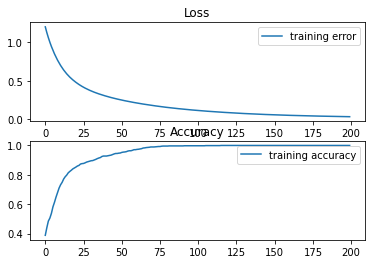

In [ ]:
#without dropout and tanh,tanh

optimizer = Adam(learning_rate=0.0001)
score, yProbs, yClasses = evaluateAndPlot(trainXF, catTrainYF, testXF, catTestYF, 1, 200, 971, (10, 10, 7, 5), 3, optimizer)
#run_experiment(catTestYF, testYF, score, yProbs, yClasses)

In [ ]:
run_experiment(catTestYF, testYF, score, yProbs, yClasses)

Accuracy: 65.14382362365723
Precision: 0.648916
Recall: 0.651438
F1 score: 0.647524
[[200   0   0]
 [  0 116  85]
 [  0 121  69]]


Epoch 1/200
1/1 [==============================] - 0s 2ms/step - loss: 1.3964 - accuracy: 0.2791
Epoch 2/200
1/1 [==============================] - 0s 2ms/step - loss: 1.3017 - accuracy: 0.3450
Epoch 3/200
1/1 [==============================] - 0s 1ms/step - loss: 1.2680 - accuracy: 0.3419
Epoch 4/200
1/1 [==============================] - 0s 1ms/step - loss: 1.1913 - accuracy: 0.4181
Epoch 5/200
1/1 [==============================] - 0s 2ms/step - loss: 1.1419 - accuracy: 0.4212
Epoch 6/200
1/1 [==============================] - 0s 2ms/step - loss: 1.1031 - accuracy: 0.4408
Epoch 7/200
1/1 [==============================] - 0s 2ms/step - loss: 1.0296 - accuracy: 0.4871
Epoch 8/200
1/1 [==============================] - 0s 2ms/step - loss: 1.0229 - accuracy: 0.4902
Epoch 9/200
1/1 [==============================] - 0s 2ms/step - loss: 0.9872 - accuracy: 0.5170
Epoch 10/200
1/1 [==============================] - 0s 1ms/step - loss: 0.9673 - accuracy: 0.5160
Epoch 11/200
1/1 [===========

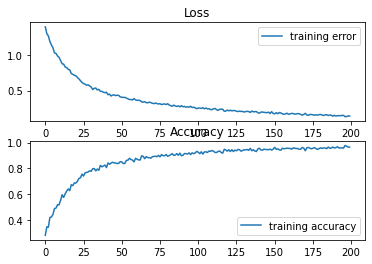

Accuracy: 62.4365508556366
Precision: 0.622788
Recall: 0.624365
F1 score: 0.622832
[[200   0   0]
 [  0 100 101]
 [  0 121  69]]


In [ ]:
# with dropout and tanh, tanh

optimizer = Adam(learning_rate=0.0001)
score, yProbs, yClasses = evaluateAndPlot(trainXF, catTrainYF, testXF, catTestYF, 1, 200, 971, (10, 10, 7, 5), 3, optimizer)
run_experiment(catTestYF, testYF, score, yProbs, yClasses)